In [1]:
import random
import sys
sys.path.append('src/')
sys.path.append('experiments/')
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_squared_error
from sklearn.model_selection import train_test_split

from src.clause_generator import ClauseGenerator
from src.ilp_solver import ILPSolver
from src.ilp_problem import ILPProblem
from src.data_utils import DataUtils
from src.visualize import Visualize
from experiments.parameters import get_parameters
from experiments.eval_utils import get_dataset_with_noise, compute_auc, compute_mse, extract

In [2]:
### problem
problem = 'member'
#problem = 'delete'
#problem = 'plus'
#problem = 'append'
#problem = 'subtree'

### noise_rate
noise_rate = 0.05

In [3]:
test_size = 0.3
du = DataUtils(problem)
pos, neg, bk, clauses, lang = du.load_data()
pos_train, pos_test = train_test_split(
    pos, test_size=test_size, random_state=7014)
neg_train, neg_test = train_test_split(
    neg, test_size=test_size, random_state=7014)

N_beam, T_beam, T, m = get_parameters(problem)

### add noise
pos_train_, neg_train_ = get_dataset_with_noise(pos_train, neg_train, noise_rate=noise_rate)
ilp_train = ILPProblem(pos_train_, neg_train_, bk, lang, name=problem)
ilp_train.print()

======= POSITIVE EXAMPLES =======
[append(*,f(b,f(b,f(a,*))),f(b,f(b,f(a,*)))), append(*,f(b,f(c,*)),f(b,f(c,*))), append(f(b,f(a,f(a,*))),f(a,f(b,f(a,*))),f(b,f(a,f(a,f(a,f(b,f(a,*))))))), append(f(a,f(a,*)),f(b,*),f(a,f(a,f(b,*)))), append(f(a,f(a,*)),*,f(a,f(a,*))), append(f(b,f(c,*)),f(a,f(b,*)),f(b,f(c,f(a,f(b,*))))), append(f(b,*),f(a,f(c,*)),f(b,f(a,f(c,*)))), append(f(b,*),f(b,f(c,*)),f(b,f(b,f(c,*)))), append(f(b,*),f(a,f(a,*)),f(b,f(a,f(a,*)))), append(f(b,f(c,*)),f(a,f(a,f(b,*))),f(b,f(c,f(a,f(a,f(b,*)))))), append(f(a,f(b,f(a,*))),f(a,*),f(a,f(b,f(a,f(a,*))))), append(f(a,f(a,*)),f(c,f(b,*)),f(a,f(a,f(c,f(b,*))))), append(f(c,f(b,*)),f(a,f(a,*)),f(c,f(b,f(a,f(a,*))))), append(f(a,f(a,f(b,*))),f(b,f(c,*)),f(a,f(a,f(b,f(b,f(c,*)))))), append(*,f(c,f(c,f(c,*))),f(c,f(c,f(c,*)))), append(f(b,*),f(c,f(c,f(b,*))),f(b,f(c,f(c,f(b,*))))), append(*,f(a,f(a,*)),f(a,f(a,*))), append(f(a,*),f(a,*),f(a,f(a,*))), append(f(c,*),f(a,f(c,*)),f(c,f(a,f(c,*)))), append(*,f(b,*),f(b,*)), appen

In [4]:
CG = ClauseGenerator(ilp_train, infer_step=T, max_depth=1, max_body_len=1)
solver = ILPSolver(ilp_train, C_0=clauses, CG=CG, m=m, infer_step=T)

In [6]:
N_max = 50 # maximum number of clauses
lr = 1e-2
epoch = 2000

### train weights
clauses, Ws, loss_list = solver.train(
        gen_mode='beam', N_max=N_max, T_beam=T_beam, N_beam=N_beam, epoch=epoch, lr=lr, wd=0.0)

Generating clauses...
======= BEAM SEARCHED CLAUSES ======
append(*,X,X):-.
append(*,X,Y):-.
append(X,*,Y):-.
append(X,X,Y):-.
append(X,Y,X):-.
append(X,Y,Y):-.
append(X,Y,Z):-.
append(X,Y,Z):-append(Y,Z,X).
append(X,Y,Z):-append(Z,Y,X).
append(X,Y,f(Z,V)):-.
append(X,Y,f(Z,V)):-append(V,X,Y).
append(X,Y,f(Z,V)):-append(Y,V,X).
append(X,Y,f(Z,X)):-.
append(X,Y,f(Z,Y)):-.
append(X,f(Y,Z),V):-.
append(X,f(Y,Z),f(V,W)):-.
append(X,f(Y,Z),f(V,W)):-append(X,W,Z).
append(X,f(Y,Z),f(V,W)):-append(X,Z,W).
append(X,f(Y,Z),f(V,W)):-append(Z,X,W).
append(X,f(Y,Z),f(V,Z)):-.
append(X,f(Y,Z),f(V,Z)):-append(X,Z,Z).
append(X,f(Y,Z),f(Y,V)):-.
append(X,f(Y,Z),f(Y,V)):-append(X,V,Z).
append(X,f(Y,Z),f(Y,V)):-append(X,Z,V).
append(X,f(Y,Z),f(Y,Z)):-.
append(f(X,Y),Z,V):-.
append(f(X,Y),Z,f(V,W)):-.
append(f(X,Y),Z,f(V,W)):-append(Z,Y,W).
append(f(X,Y),Z,f(V,Z)):-.
append(f(X,Y),Z,f(X,V)):-.
append(f(X,Y),Z,f(X,V)):-append(V,Z,Y).
append(f(X,Y),Z,f(X,V)):-append(Y,Z,V).
append(f(X,Y),Z,f(X,V)):-append(Z

  0%|          | 3/2000 [00:00<01:12, 27.49it/s, loss=0.985]

Learning weights...


100%|██████████| 2000/2000 [01:02<00:00, 32.25it/s, loss=1.4e-5] 


====== LEARNED PROGRAM ======
C_0:  append(f(X,Y),Z,f(X,V)):-append(Y,Z,V). 0.3628360331058502
C_1:  append(f(X,Y),Z,f(X,V)):-append(Y,Z,V). 0.9506579637527466
C_2:  append(*,X,X):-. 1.0


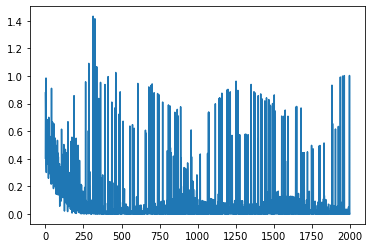

In [7]:
### plot training loss
%matplotlib inline
plt.plot(loss_list)
plt.show()

In [8]:
### evaluate on test data
v_list, facts = solver.predict(pos_test, neg_test, clauses, Ws)
mse = compute_mse(pos_test, neg_test, v_list, facts)
auc = compute_auc(pos_test, neg_test, v_list, facts)

print('====== TEST SCORE =======')
print('Mean-squared test error: ', mse)
print('AUC: ', auc)

Enumerating facts...
Building tensors...
====== TEST SCORE =======
Mean-squared test error:  0.000552295560554351
AUC:  1.0


Enumerating facts...
Building tensors...


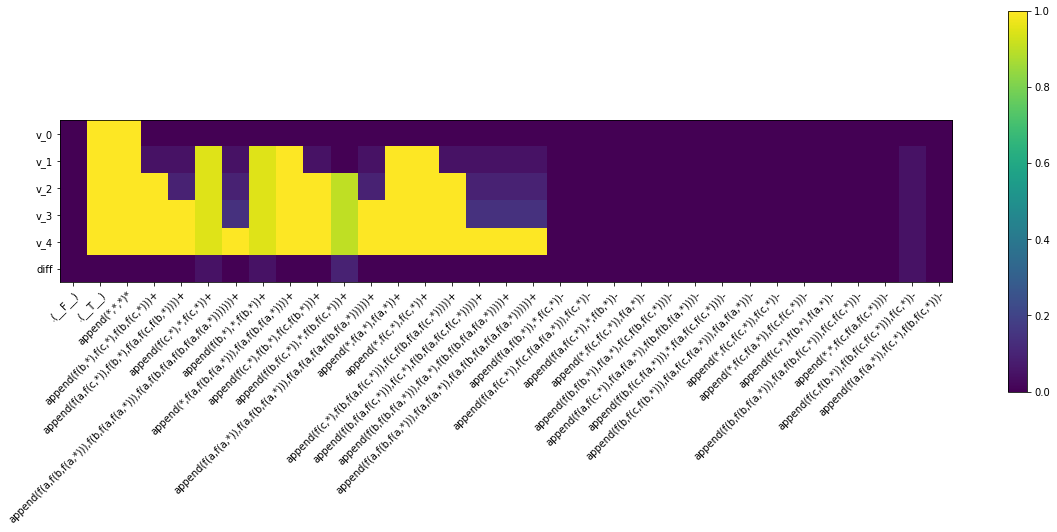

In [9]:
# Visualize v_0, v_1, ..., v_n after learning

v_list, facts = solver.get_valuation_memory(pos_test, neg_test, clauses, Ws)
ilp_test = ILPProblem(pos_test, neg_test, bk, lang, name=problem)
vis = Visualize(ilp_test, name=problem, facts=facts)
vis.plot_valuation_memory(v_list)